In [58]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import sklearn
from xgboost import XGBRegressor
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import f1_score
import joblib
from sklearn.cluster import KMeans
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [49]:
import numpy as np

# Manually creating lists of file paths
trace_files = [
    "dataset/trace_0.npy", "dataset/trace_3.npy", "dataset/trace_4.npy", 
    # "dataset/trace_5.npy",
    "dataset/trace_6.npy", "dataset/trace_7.npy", 
    "dataset/trace_8.npy", "dataset/trace_9.npy", "dataset/trace_10.npy"
]

gt_files = [
    "dataset/gt_0.npy", "dataset/gt_2.npy", "dataset/gt_3.npy", 
    # "dataset/gt_4.npy", 
    "dataset/gt_5.npy", "dataset/gt_6.npy", 
    "dataset/gt_7.npy", "dataset/gt_8.npy", "dataset/gt_9.npy"
]

trace = np.concatenate([np.load(f) for f in trace_files])
gt = np.concatenate([np.load(f) for f in gt_files])
train_sequences = []
novel_sequences = []

for i in range(0, len(trace), 1200):
    sequence = trace[i:i+1200]
    ground_truth = gt[i:i+1200]


    if(len(sequence) != 1200):
        continue
    
    isNovel = False
    count = 0
    for truth in ground_truth:
        if truth == 2: 
            # count = count + 1
            # if count > 500:
                isNovel = True
                break
    if isNovel:
        novel_sequences.append(sequence)
        pass
    else: 
        train_sequences.append(sequence)

train_sequences_array = np.array(train_sequences)
novel_sequences_array = np.array(novel_sequences)
train_sequences_array.shape, novel_sequences_array.shape

X_train_reshaped = train_sequences_array.reshape(train_sequences_array.shape[0], -1)

X_train, X_val = train_test_split(X_train_reshaped, test_size=0.2, random_state=0)

novel_sequences_reshaped = novel_sequences_array.reshape(novel_sequences_array.shape[0], -1)

# Concatenating with the validation set
X_test = np.concatenate((X_val, novel_sequences_reshaped), axis=0)

# XGBoost


              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       346
         1.0       0.99      0.99      0.99       194

    accuracy                           0.99       540
   macro avg       0.99      0.99      0.99       540
weighted avg       0.99      0.99      0.99       540

Overall F1 Score: 0.9944444444444445


<Axes: >

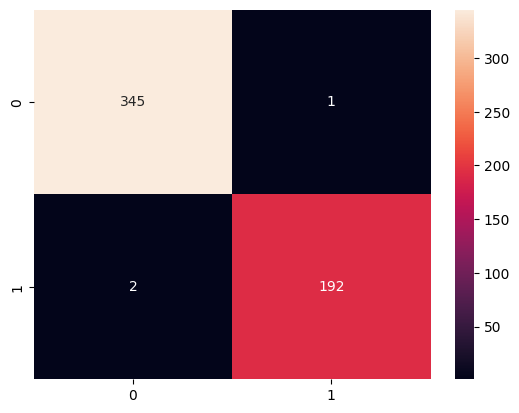

In [57]:
from xgboost import XGBRegressor

# Create a model instance
loaded_model = XGBRegressor()

# Load the model from the file
loaded_model.load_model('xgb_model.bin')
batch_size = 10000 
error = np.empty_like(X_test)

# Process in batches to avoid memory issues
for i in range(0, len(X_test), batch_size):
    end = min(i + batch_size, len(X_test))
    batch_pred = loaded_model.predict(X_test[i:end])
    
    # Ensure that batch_pred is reshaped to match the dimensions of X_test
    # If X_test is 2D (n_samples, n_features), batch_pred should also be reshaped to this format
    batch_pred_reshaped = batch_pred.reshape(-1, X_test.shape[1])
    
    # Calculate the error for this batch
    error[i:end] = X_test[i:end] - batch_pred_reshaped
from sklearn.metrics import classification_report

# Assuming error is already computed
threshold = np.percentile(np.abs(error), 95)
anomalies = np.abs(error) > threshold

# Assuming X_test_train and novel_sequences_array are already defined and correctly shaped
gt_test = np.concatenate((np.zeros(len(X_val)), np.ones(len(novel_sequences_array))))

# Reshape anomalies to match the shape of X_test and then convert to binary format
anomalies_reshaped = anomalies.reshape(X_test.shape[0], -1)
anomalies_binary = anomalies_reshaped.any(axis=1).astype(int)

# Classification report to evaluate model performance
print(classification_report(gt_test, anomalies_binary))

overall_f1 = f1_score(gt_test, anomalies_binary, average='micro')

print("Overall F1 Score:", overall_f1)

sns.heatmap(confusion_matrix(gt_test,anomalies_binary),annot = True,fmt='g')

# KMeans

In [44]:
kmeans = joblib.load('kmeans.pkl')
# Find the distance of each point in the test set to the nearest cluster center
distances = kmeans.transform(X_test)
min_distances = np.min(distances, axis=1)

threshold = np.percentile(min_distances, 65)  

# Identify novelties
# A novelty in this case is a data point whose distance to the nearest cluster center is greater than the threshold
novelties = min_distances > threshold

# Ground truth - assuming the first part of X_test is normal (0) and the latter part is novel/anomalous (1)
ground_truth = np.concatenate((np.zeros(len(X_val)), np.ones(len(novel_sequences_array))))

# Classification report
print(classification_report(ground_truth, novelties))


overall_f1 = f1_score(ground_truth, novelties, average='micro')

print("Overall F1 Score:", overall_f1)

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       346
         1.0       1.00      0.97      0.99       194

    accuracy                           0.99       540
   macro avg       0.99      0.99      0.99       540
weighted avg       0.99      0.99      0.99       540

Overall F1 Score: 0.9907407407407407


# Autoencoder

In [43]:
autoencoder = load_model('autoencoder_model.h5')
y_test_pred = autoencoder.predict(X_test)
# Calculate the reconstruction error
reconstruction_error = np.mean(np.abs(X_test- y_test_pred), axis=1)

# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 65)

# Detect anomalies
anomalies = reconstruction_error > threshold

# Evaluation
ground_truth = np.concatenate((np.zeros(len(X_val)), np.ones(len(novel_sequences_array))))
# print("Shapes - true_anomalies:", true_anomalies.shape, "anomalies:", anomalies.shape)
print(classification_report(ground_truth, anomalies))

overall_f1 = f1_score(ground_truth, anomalies, average='micro')

print("Overall F1 Score:", overall_f1)

17/17 [==============================] - 5s 73ms/step
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96       346
         1.0       0.93      0.91      0.92       194

    accuracy                           0.94       540
   macro avg       0.94      0.93      0.94       540
weighted avg       0.94      0.94      0.94       540

Overall F1 Score: 0.9425925925925925


# GPU TESTING


In [26]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [25]:
import tensorflow as tf

# Check available GPUs
gpus = tf.config.list_physical_devices('GPU')

# If GPUs are detected, we'll print their details
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs available: {len(gpus)} - Details: {gpus}")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPUs available.")


No GPUs available.
